# Pseudo Virtual Fields: Neural Networks act as Taylor expansions to find optimal virtual fields via weak equilibrium minimization

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from helper_FEBIO import *
from VF_helper import *
from model import *
from plot_helper import *

In [4]:
import sys
sys.path.insert(0, '../')
from core import *
#config
from config import *
#CUDA
cuda=0
device=initCUDA(cuda)
#supporting files


-----------------------------------------------------
Setting device to:  0


/home/feolalab/anaconda3/envs/NNEUCLID/lib/python3.9/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


Test:  cuda:0
-----------------------------------------------------



# Read FEBIO data

In [ ]:
#Read connectivity
connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/connectivity")
connectivity

,1,1,9,133,52,24,57,153,108
0,2,9,10,134,133,57,58,154,153
1,3,10,11,135,134,58,59,155,154
2,4,11,12,136,135,59,60,156,155
3,5,12,2,25,136,60,13,73,156
4,6,52,133,129,51,108,153,157,107
...,...,...,...,...,...,...,...,...,...
119,121,117,213,104,44,56,149,45,8
120,122,213,214,103,104,149,150,46,45
121,123,214,215,102,103,150,151,47,46
122,124,215,216,101,102,151,152,48,47


In [ ]:
#Read connectivity
facet_connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/facet_area_connectivity")
facet_connectivity

,1,1,9,57,24
0,2,52,1,24,108
1,3,52,133,9,1
2,4,9,10,58,57
3,5,133,134,10,9
4,6,10,11,59,58
...,...,...,...,...,...
144,146,101,102,47,48
145,147,151,152,48,47
146,148,88,32,7,33
147,149,32,101,48,7


### Function to read multiple states from FEBIO file

In [8]:
volume_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/volume"
volume=read_multi_ste_output2(volume_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=125
 State 2: element=125
 State 3: element=125
 State 4: element=125
 State 5: element=125
 State 6: element=125
 State 7: element=125
 State 8: element=125
 State 9: element=125
 State 10: element=125
 State 11: element=125


In [9]:
area_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/facet_area"
area=read_multi_ste_output2(area_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=150
 State 2: element=150
 State 3: element=150
 State 4: element=150
 State 5: element=150
 State 6: element=150
 State 7: element=150
 State 8: element=150
 State 9: element=150
 State 10: element=150
 State 11: element=150


In [10]:
stress_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/stress"
stress=read_multi_ste_output_VOIGT(stress_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'yz', 'xz']
Number of states: 11
 State 1: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 2: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 3: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 4: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 5: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 6: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 7: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 8: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 9: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 10: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 11: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125


In [12]:
F_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/deformation_tensor.txt"
F=read_multi_stepped_output_txt(F_file,p=True)

Step 0: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 1: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 2: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 3: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 4: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 5: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 6: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 7: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 8: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 9: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 10: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125


In [13]:
surface_normal_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/surface_normal"
surface_normal=read_multi_ste_output_VOIGT(surface_normal_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=150, y=150, z=150
 State 2: x=150, y=150, z=150
 State 3: x=150, y=150, z=150
 State 4: x=150, y=150, z=150
 State 5: x=150, y=150, z=150
 State 6: x=150, y=150, z=150
 State 7: x=150, y=150, z=150
 State 8: x=150, y=150, z=150
 State 9: x=150, y=150, z=150
 State 10: x=150, y=150, z=150
 State 11: x=150, y=150, z=150


In [14]:
position_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/position"
position=read_multi_ste_output_VOIGT(position_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=216, y=216, z=216
 State 2: x=216, y=216, z=216
 State 3: x=216, y=216, z=216
 State 4: x=216, y=216, z=216
 State 5: x=216, y=216, z=216
 State 6: x=216, y=216, z=216
 State 7: x=216, y=216, z=216
 State 8: x=216, y=216, z=216
 State 9: x=216, y=216, z=216
 State 10: x=216, y=216, z=216
 State 11: x=216, y=216, z=216


In [15]:
strain_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/lagrange_strain"
strain=read_multi_ste_output_VOIGT(strain_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'yz', 'xz']
Number of states: 11
 State 1: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 2: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 3: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 4: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 5: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 6: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 7: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 8: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 9: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 10: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 11: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125


### Log file data

In [19]:
centroids_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/centroids.txt"
centroids_dict=read_multi_stepped_output_txt(centroids_file,p=True)

Step 0: x=125, y=125, z=125
Step 1: x=125, y=125, z=125
Step 2: x=125, y=125, z=125
Step 3: x=125, y=125, z=125
Step 4: x=125, y=125, z=125
Step 5: x=125, y=125, z=125
Step 6: x=125, y=125, z=125
Step 7: x=125, y=125, z=125
Step 8: x=125, y=125, z=125
Step 9: x=125, y=125, z=125
Step 10: x=125, y=125, z=125


In [ ]:
#Centroids from log file
#centroids_file='/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/Model1.log'
#centroids_dict  = parse_states(centroids_file)

#Should get 11 states, each with exactly 1000 x/y/z values:
#print("states found:", sorted(centroids_dict.keys()))
#for step, d in centroids_dict.items():
    #print(f" step {step:2d}: x={len(d['x'])} pts, y={len(d['y'])}, z={len(d['z'])}")

states found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 step  0: x=0 pts, y=0, z=0
 step  1: x=0 pts, y=0, z=0
 step  2: x=0 pts, y=0, z=0
 step  3: x=0 pts, y=0, z=0
 step  4: x=0 pts, y=0, z=0
 step  5: x=0 pts, y=0, z=0
 step  6: x=0 pts, y=0, z=0
 step  7: x=0 pts, y=0, z=0
 step  8: x=0 pts, y=0, z=0
 step  9: x=0 pts, y=0, z=0
 step 10: x=0 pts, y=0, z=0


### State dict to tensor

In [20]:
# 1) Build a (Nelements,3,nstates) tensor for centroids:
centroids_tensor = states_to_tensor(centroids_dict, ['x','y','z'])
print("centroids_tensor.shape:", centroids_tensor.shape)
# → (Nelements, 3, nstates)

# 2) Build a (Nelements,6,nstates) tensor for volume‐stress:
stress_tensor = states_to_tensor(stress,
                                ['xx','yy','zz','xy','xz','yz'])
print("stress_tensor.shape:", stress_tensor.shape)
# → (Nelements, 6, nstates)

# 3) If you just want the x‐only channel across states:
#x_only = states_to_tensor(centroids_dict, ['x'])
#print("x_only.shape:", x_only.shape)
# → (Nelements, 1, nstates)

# 3) Volume:
volume_tensor = states_to_tensor(volume, ['element'])
print("volume_tensor.shape:", volume_tensor.shape)
# → (Nelements, 1, nstates)

# 4) Deformation tensor:
F_tensor = states_to_tensor(F, ['Fxx','Fxy','Fxz','Fyx','Fyy','Fyz','Fzx','Fzy','Fzz'])
print("F_tensor.shape:", F_tensor.shape)

# 4) Surface Normal:
surface_normal_tensor = states_to_tensor(surface_normal, ['x','y','z'])
print("surface_normal_tensor.shape:", surface_normal_tensor.shape)


# 5) Area:
area_tensor = states_to_tensor(area, ['element'])
print("area_tensor.shape:", area_tensor.shape)


# 6) Strain:
#del strain[1]
strain_tensor = states_to_tensor(strain, ['xx','yy','zz','xy','xz','yz'])
print("strain_tensor.shape:", strain_tensor.shape)

position_tensor = states_to_tensor(position, ['x','y','z'])
print("strain_tensor.shape:", position_tensor.shape)

centroids_tensor.shape: torch.Size([125, 3, 11])
stress_tensor.shape: torch.Size([125, 6, 11])
volume_tensor.shape: torch.Size([125, 1, 11])
F_tensor.shape: torch.Size([125, 9, 11])
surface_normal_tensor.shape: torch.Size([150, 3, 11])
area_tensor.shape: torch.Size([150, 1, 11])
strain_tensor.shape: torch.Size([125, 6, 11])
strain_tensor.shape: torch.Size([216, 3, 11])


In [21]:
position_tensor = states_to_tensor(position, ['x','y','z'])
print("strain_tensor.shape:", position_tensor.shape)

strain_tensor.shape: torch.Size([216, 3, 11])


In [22]:
torch.sum(centroids_tensor[:,:,0], dim=(0,1))

tensor(87.5000, dtype=torch.float32)

In [60]:
Nelements=F_tensor.shape[0]
Nelements

125

## Where pressure is applied and Zero Displacement Boundary Conditions

In [23]:
pressure_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/Model1.feb", surface_name="Pressure1")
pressure_node_ids = list(pressure_nodes.keys())

In [24]:
pressure_nodes[1], type(pressure_nodes)

([5, 20, 137, 53], dict)

In [25]:
ZD_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/Model1.feb", surface_name="ZeroDisplacement1")
ZD_node_ids = list(ZD_nodes.keys())
ZD_idx = torch.tensor([nid - 1 for nid in ZD_node_ids], dtype=torch.long)
ZD_idx[:10], ZD_node_ids[:10]

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [26]:
ZD_nodes[1], len(ZD_node_ids)

([4, 40, 121, 49], 25)

In [27]:
connectivity_list = [
    tuple(map(int, row))           # ensure ints
    for row in connectivity.values
]

In [28]:
# 2) Flatten pressure-node dict into a set of node IDs
pressure_nodes_set = {
    n
    for nodes in pressure_nodes.values()
    for n in nodes
}

mapping_element_pressure = map_pressure_to_elements(connectivity_list, pressure_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_pressure.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 101:
  all_nodes:      [21, 69, 201, 120, 5, 20, 137, 53]
  pressure_nodes: [5, 20, 137, 53]
Element 102:
  all_nodes:      [69, 70, 202, 201, 20, 19, 138, 137]
  pressure_nodes: [20, 19, 138, 137]
Element 103:
  all_nodes:      [70, 71, 203, 202, 19, 18, 139, 138]
  pressure_nodes: [19, 18, 139, 138]
Element 104:
  all_nodes:      [71, 72, 204, 203, 18, 17, 140, 139]
  pressure_nodes: [18, 17, 140, 139]
Element 105:
  all_nodes:      [72, 16, 85, 204, 17, 6, 36, 140]
  pressure_nodes: [17, 6, 36, 140]
Element 106:
  all_nodes:      [120, 201, 205, 119, 53, 137, 141, 54]
  pressure_nodes: [53, 137, 141, 54]
Element 107:
  all_nodes:      [201, 202, 206, 205, 137, 138, 142, 141]
  pressure_nodes: [137, 138, 142, 141]
Element 108:
  all_nodes:      [202, 203, 207, 206, 138, 139, 143, 142]
  pressure_nodes: [138, 139, 143, 142]
Element 109:
  all_nodes:      [203, 204, 208, 207, 139, 140, 144, 143]
  pressure_nodes: [139, 140, 144, 143]
Element 110:
  all_nodes:      [204, 85, 86,

In [29]:
# 2) Flatten pressure-node dict into a set of node IDs
ZD_nodes_set = {
    n
    for nodes in ZD_nodes.values()
    for n in nodes
}

mapping_element_ZD = map_pressure_to_elements(connectivity_list, ZD_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_ZD.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 2:
  all_nodes:      [9, 10, 134, 133, 57, 58, 154, 153]
  pressure_nodes: [9, 10, 134, 133]
Element 3:
  all_nodes:      [10, 11, 135, 134, 58, 59, 155, 154]
  pressure_nodes: [10, 11, 135, 134]
Element 4:
  all_nodes:      [11, 12, 136, 135, 59, 60, 156, 155]
  pressure_nodes: [11, 12, 136, 135]
Element 5:
  all_nodes:      [12, 2, 25, 136, 60, 13, 73, 156]
  pressure_nodes: [12, 2, 25, 136]
Element 6:
  all_nodes:      [52, 133, 129, 51, 108, 153, 157, 107]
  pressure_nodes: [52, 133, 129, 51]
Element 7:
  all_nodes:      [133, 134, 130, 129, 153, 154, 158, 157]
  pressure_nodes: [133, 134, 130, 129]
Element 8:
  all_nodes:      [134, 135, 131, 130, 154, 155, 159, 158]
  pressure_nodes: [134, 135, 131, 130]
Element 9:
  all_nodes:      [135, 136, 132, 131, 155, 156, 160, 159]
  pressure_nodes: [135, 136, 132, 131]
Element 10:
  all_nodes:      [136, 25, 26, 132, 156, 73, 74, 160]
  pressure_nodes: [136, 25, 26, 132]
Element 11:
  all_nodes:      [51, 129, 125, 50, 107, 157, 

In [30]:
pressure_element_IDs=list(mapping_element_pressure.keys())

pressure_element_IDs_final = torch.tensor([nid - 1 for nid in pressure_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [31]:
ZD_element_IDs=list(mapping_element_ZD.keys())

ZD_element_IDs_final = torch.tensor([nid - 1 for nid in ZD_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [32]:
ZD_element_IDs_final

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24])

In [33]:
#Get normals of surfaces where pressure is applied
# 1) zero‐based indices for those nodes:
idx = torch.tensor([nid - 1 for nid in pressure_node_ids], dtype=torch.long)
idx_ZD = torch.tensor([nid - 1 for nid in ZD_node_ids], dtype=torch.long)

# 2) index into the first dimension:
#    result has shape (100, 3, 11)
pressure_normals = surface_normal_tensor[idx, :, :]
area_normals = area_tensor[idx, :, :]

#ZD:
ZD_normals = surface_normal_tensor[idx_ZD, :, :]
ZD_areas = area_tensor[idx_ZD, :, :]


print(pressure_normals.shape)  # → torch.Size([100, 3, 11])
print(ZD_normals.shape)  # → torch.Size([100, 3, 11])

torch.Size([25, 3, 11])
torch.Size([25, 3, 11])


In [34]:
#print("VF.shape =", VF.shape)
print("max idx =", max(pressure_element_IDs_final).item())
print("min idx =", min(pressure_element_IDs_final).item())


max idx = 124
min idx = 100


# Surface Normals

In [35]:
surface_normal_tensor.shape

torch.Size([150, 3, 11])

In [36]:
facet_connectivity_list = [
    tuple(map(int, row))           # ensure ints
    for row in facet_connectivity.values
]

In [37]:
facet_connectivity_list

[(2, 52, 1, 24, 108),
 (3, 52, 133, 9, 1),
 (4, 9, 10, 58, 57),
 (5, 133, 134, 10, 9),
 (6, 10, 11, 59, 58),
 (7, 134, 135, 11, 10),
 (8, 11, 12, 60, 59),
 (9, 135, 136, 12, 11),
 (10, 12, 2, 13, 60),
 (11, 2, 25, 73, 13),
 (12, 136, 25, 2, 12),
 (13, 51, 52, 108, 107),
 (14, 51, 129, 133, 52),
 (15, 129, 130, 134, 133),
 (16, 130, 131, 135, 134),
 (17, 131, 132, 136, 135),
 (18, 25, 26, 74, 73),
 (19, 132, 26, 25, 136),
 (20, 50, 51, 107, 106),
 (21, 50, 125, 129, 51),
 (22, 125, 126, 130, 129),
 (23, 126, 127, 131, 130),
 (24, 127, 128, 132, 131),
 (25, 26, 27, 75, 74),
 (26, 128, 27, 26, 132),
 (27, 49, 50, 106, 105),
 (28, 49, 121, 125, 50),
 (29, 121, 122, 126, 125),
 (30, 122, 123, 127, 126),
 (31, 123, 124, 128, 127),
 (32, 27, 28, 76, 75),
 (33, 124, 28, 27, 128),
 (34, 40, 4, 41, 92),
 (35, 4, 49, 105, 41),
 (36, 4, 40, 121, 49),
 (37, 39, 40, 92, 91),
 (38, 40, 39, 122, 121),
 (39, 38, 39, 91, 90),
 (40, 39, 38, 123, 122),
 (41, 37, 38, 90, 89),
 (42, 38, 37, 124, 123),
 (43,

In [38]:
facet2elems = map_facets_to_elements(connectivity_list, facet_connectivity_list)
for fid, info in facet2elems.items():
    print(f"Facet {fid} with nodes {info['facet_nodes']} → elements {info['element_ids']}")

Facet 4 with nodes [9, 10, 58, 57] → elements [2]
Facet 5 with nodes [133, 134, 10, 9] → elements [2]
Facet 6 with nodes [10, 11, 59, 58] → elements [3]
Facet 7 with nodes [134, 135, 11, 10] → elements [3]
Facet 8 with nodes [11, 12, 60, 59] → elements [4]
Facet 9 with nodes [135, 136, 12, 11] → elements [4]
Facet 10 with nodes [12, 2, 13, 60] → elements [5]
Facet 11 with nodes [2, 25, 73, 13] → elements [5]
Facet 12 with nodes [136, 25, 2, 12] → elements [5]
Facet 13 with nodes [51, 52, 108, 107] → elements [6]
Facet 14 with nodes [51, 129, 133, 52] → elements [6]
Facet 15 with nodes [129, 130, 134, 133] → elements [7]
Facet 16 with nodes [130, 131, 135, 134] → elements [8]
Facet 17 with nodes [131, 132, 136, 135] → elements [9]
Facet 18 with nodes [25, 26, 74, 73] → elements [10]
Facet 19 with nodes [132, 26, 25, 136] → elements [10]
Facet 20 with nodes [50, 51, 107, 106] → elements [11]
Facet 21 with nodes [50, 125, 129, 51] → elements [11]
Facet 22 with nodes [125, 126, 130, 129] →

In [39]:
element2facets = {}
for facet_id, info in facet2elems.items():
    for eid in info['element_ids']:
        element2facets.setdefault(eid, []).append(facet_id) 
element2facets

{2: [4, 5],
 3: [6, 7],
 4: [8, 9],
 5: [10, 11, 12],
 6: [13, 14],
 7: [15],
 8: [16],
 9: [17],
 10: [18, 19],
 11: [20, 21],
 12: [22],
 13: [23],
 14: [24],
 15: [25, 26],
 16: [27, 28],
 17: [29],
 18: [30],
 19: [31],
 20: [32, 33],
 21: [34, 35, 36],
 22: [37, 38],
 23: [39, 40],
 24: [41, 42],
 25: [43, 44, 45],
 26: [46, 47],
 27: [48],
 28: [49],
 29: [50],
 30: [51, 52],
 31: [53],
 35: [54],
 36: [55],
 40: [56],
 41: [57],
 45: [58],
 46: [59, 60],
 47: [61],
 48: [62],
 49: [63],
 50: [64, 65],
 51: [66, 67],
 52: [68],
 53: [69],
 54: [70],
 55: [71, 72],
 56: [73],
 60: [74],
 61: [75],
 65: [76],
 66: [77],
 70: [78],
 71: [79, 80],
 72: [81],
 73: [82],
 74: [83],
 75: [84, 85],
 76: [86, 87],
 77: [88],
 78: [89],
 79: [90],
 80: [91, 92],
 81: [93],
 85: [94],
 86: [95],
 90: [96],
 91: [97],
 95: [98],
 96: [99, 100],
 97: [101],
 98: [102],
 99: [103],
 100: [104, 105],
 101: [106, 107, 108],
 102: [109, 110],
 103: [111, 112],
 104: [113, 114],
 105: [115, 116, 1

In [40]:
eid, idx

(125,
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24]))

In [41]:
# 1) select only the pressured elements
pressure_elements_facets = {
    eid-1: element2facets[eid] #minus one to account for python indexing
    for eid in pressure_element_IDs
    if eid in element2facets
}

In [42]:
for eid, info in mapping_element_pressure.items():
    pset = set(info['pressure_nodes'])
    # find the facet(s) whose node-set exactly matches the pressure nodes
    facet_ids = [
        fid
        for fid, n1, n2, n3, n4 in facet_connectivity_list
        if set((n1, n2, n3, n4)) == pset
    ]
    info['facet_ids'] = facet_ids

# inspect
for eid, info in mapping_element_pressure.items():
    print(f"Element {eid}:")
    print("  all_nodes:      ", info['all_nodes'])
    print("  pressure_nodes: ", info['pressure_nodes'])
    print("  facet_ids:      ", info.get('facet_ids', []))

Element 101:
  all_nodes:       [21, 69, 201, 120, 5, 20, 137, 53]
  pressure_nodes:  [5, 20, 137, 53]
  facet_ids:       [108]
Element 102:
  all_nodes:       [69, 70, 202, 201, 20, 19, 138, 137]
  pressure_nodes:  [20, 19, 138, 137]
  facet_ids:       [110]
Element 103:
  all_nodes:       [70, 71, 203, 202, 19, 18, 139, 138]
  pressure_nodes:  [19, 18, 139, 138]
  facet_ids:       [112]
Element 104:
  all_nodes:       [71, 72, 204, 203, 18, 17, 140, 139]
  pressure_nodes:  [18, 17, 140, 139]
  facet_ids:       [114]
Element 105:
  all_nodes:       [72, 16, 85, 204, 17, 6, 36, 140]
  pressure_nodes:  [17, 6, 36, 140]
  facet_ids:       [117]
Element 106:
  all_nodes:       [120, 201, 205, 119, 53, 137, 141, 54]
  pressure_nodes:  [53, 137, 141, 54]
  facet_ids:       [119]
Element 107:
  all_nodes:       [201, 202, 206, 205, 137, 138, 142, 141]
  pressure_nodes:  [137, 138, 142, 141]
  facet_ids:       [120]
Element 108:
  all_nodes:       [202, 203, 207, 206, 138, 139, 143, 142]
  pr

In [43]:
for eid, info in mapping_element_ZD.items():
    pset = set(info['pressure_nodes'])
    # find the facet(s) whose node-set exactly matches the pressure nodes
    facet_ids = [
        fid
        for fid, n1, n2, n3, n4 in facet_connectivity_list
        if set((n1, n2, n3, n4)) == pset
    ]
    info['facet_ids'] = facet_ids

# inspect
for eid, info in mapping_element_ZD.items():
    print(f"Element {eid}:")
    print("  all_nodes:      ", info['all_nodes'])
    print("  pressure_nodes: ", info['pressure_nodes'])
    print("  facet_ids:      ", info.get('facet_ids', []))

Element 2:
  all_nodes:       [9, 10, 134, 133, 57, 58, 154, 153]
  pressure_nodes:  [9, 10, 134, 133]
  facet_ids:       [5]
Element 3:
  all_nodes:       [10, 11, 135, 134, 58, 59, 155, 154]
  pressure_nodes:  [10, 11, 135, 134]
  facet_ids:       [7]
Element 4:
  all_nodes:       [11, 12, 136, 135, 59, 60, 156, 155]
  pressure_nodes:  [11, 12, 136, 135]
  facet_ids:       [9]
Element 5:
  all_nodes:       [12, 2, 25, 136, 60, 13, 73, 156]
  pressure_nodes:  [12, 2, 25, 136]
  facet_ids:       [12]
Element 6:
  all_nodes:       [52, 133, 129, 51, 108, 153, 157, 107]
  pressure_nodes:  [52, 133, 129, 51]
  facet_ids:       [14]
Element 7:
  all_nodes:       [133, 134, 130, 129, 153, 154, 158, 157]
  pressure_nodes:  [133, 134, 130, 129]
  facet_ids:       [15]
Element 8:
  all_nodes:       [134, 135, 131, 130, 154, 155, 159, 158]
  pressure_nodes:  [134, 135, 131, 130]
  facet_ids:       [16]
Element 9:
  all_nodes:       [135, 136, 132, 131, 155, 156, 160, 159]
  pressure_nodes:  [13

In [44]:
pressure_elem_facets_indexes = [
    (eid-1, fid-1)
    for eid, info in mapping_element_pressure.items()
    for fid in info.get('facet_ids', [])
]
pressure_elem_facets_indexes[0]

(100, 107)

In [45]:
ZD_elem_facets_indexes = [
    (eid-1, fid-1)
    for eid, info in mapping_element_ZD.items()
    for fid in info.get('facet_ids', [])
]
ZD_elem_facets_indexes[0]

(1, 4)

In [46]:
# 1) Extract index lists
elem_idxs  = torch.tensor([e for e, f in pressure_elem_facets_indexes], dtype=torch.long)
facet_idxs = torch.tensor([f for e, f in pressure_elem_facets_indexes], dtype=torch.long)

In [47]:
# 1) Extract index lists
ZD_elem_idxs  = torch.tensor([e for e, f in ZD_elem_facets_indexes], dtype=torch.long)
ZD_facet_idxs = torch.tensor([f for e, f in ZD_elem_facets_indexes], dtype=torch.long)

In [48]:
elem_idxs, ZD_elem_idxs

(tensor([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
         114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24]))

In [49]:
facet_idxs

tensor([107, 109, 111, 113, 116, 118, 119, 120, 121, 123, 125, 126, 127, 128,
        130, 132, 133, 134, 135, 137, 140, 142, 144, 146, 149])

# Architecture

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
del model

In [92]:
from model import *

vf_number=2 #linear elastic is 2 parameters
model = ICNN3D_Taylor_multifield_with_neg(n_input=3,
                n_hidden=[64,64,64],
                n_output=30,
                use_dropout=True,
                dropout_rate=0.2,
                centroids=True, p_fields=vf_number)

In [93]:
from torchinfo import summary
model = model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
ICNN3D_Taylor_multifield_with_neg        --
├─ModuleDict: 1-1                        --
│    └─Linear: 2-1                       448
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       3,900
├─ModuleDict: 1-2                        --
│    └─Linear: 2-5                       448
│    └─Linear: 2-6                       448
│    └─Linear: 2-7                       420
├─AdaptiveAvgPool1d: 1-3                 --
Total params: 13,984
Trainable params: 13,984
Non-trainable params: 0

## Training loop

In [54]:
F_tensor.shape, stress_tensor.shape, centroids_tensor.shape

(torch.Size([125, 9, 11]), torch.Size([125, 6, 11]), torch.Size([125, 3, 11]))

In [55]:
x_input= torch.cat(( F_tensor.to(device),centroids_tensor.to(device)), dim=1)
#x_input= F_tensor.to(device)
x_input.shape

torch.Size([125, 12, 11])

In [56]:
stress_tensor_3d=Voigt_to_3d_v2(stress_tensor)

V2


In [57]:
strain_tensor_3d=Voigt_to_3d_v2(strain_tensor)

V2


In [94]:
model.apply(init_weights)

ICNN3D_Taylor_multifield_with_neg(
  (layers): ModuleDict(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=60, bias=True)
  )
  (skip_layers): ModuleDict(
    (1): Linear(in_features=6, out_features=64, bias=True)
    (2): Linear(in_features=6, out_features=64, bias=True)
    (3): Linear(in_features=6, out_features=60, bias=True)
  )
  (global_pooling): AdaptiveAvgPool1d(output_size=1)
)

#### Train
If we keep the strain pointwise throughout the solid we can get a map of parameters...

In [95]:
epoch=750
# Adam with a learning rate:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#Number of states:
states=x_input.shape[2]
N_pressure_dofs=len(pressure_element_IDs_final)
N_ZD_dofs=len(ZD_element_IDs_final)
loss_list=[]
keys = ['Internal', 'External', 'ZD','Special']
work_dict = { key: [] for key in keys }
P_max  = 100000.0            # negative = compression
# make a “linear ramp” of 11 pressures from 0 → P_max
pressure_curve = torch.linspace(0.0, P_max, steps=states, device=device)
# pressure_curve.shape == (11,)
#new_lr = 1e-1
#for pg in optimizer.param_groups:
   # pg['lr'] = new_lr

for i in range(epoch):
    optimizer.zero_grad()#reset gradients
    loss = torch.zeros((), device=device)    # scalar, same dtype/device
    #Estimate
    for s in range(1,states):
        V_NN=model(x_input[:,:,s]) #This is numVF,30

        delta_xyz=calculate_point(centroids_tensor, s) #This is N elements x3

        VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 
        
        grad_VF= construct_VF_gradients_batch(V_NN, delta_xyz) #This is p,N,3,3 . 

        #Strain
        virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3))

        #Volume integral:
        
        # element‐wise inner product σ^e : ∇v^e
        integrand = torch.sum(stress_tensor_3d[:,:,:,s].unsqueeze(0) * virtual_strain, dim=(2, 3)) # → shape [p,N]
       # print(f'Integrand shape: {integrand.shape}')
        W_int = torch.sum(integrand * volume_tensor[:,0,s].unsqueeze(0) ,dim=(0,1))/(Nelements*vf_number)

       # print(f'W_int shape: {W_int.shape}')
        #Surface integral
        #Adding negative to the pressure becuase it is applied downwards...
        t_surface=-surface_normal_tensor[facet_idxs,:,s]*(pressure_curve[s]) #*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
     #   print(f'W_int shape: {W_int.shape}')

        dot = (VF_values[:,elem_idxs,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

        W_ext=torch.sum(dot*area_tensor[facet_idxs,:,s].T,dim=(0,1))/(N_pressure_dofs*vf_number)

        ## Add ZD term:
        #Elements
        #ZD_regularization=torch.sum(VF_values[:,ZD_element_IDs_final,:]**2, dim=(0,1,2))/(N_ZD_dofs*vf_number)
        #Nodes
        #VF_values_NODES = evaluate_vf_values(V_NN, position_tensor[ZD_idx,:,s]) #This is p, N, 3 
        #ZD_regularization=torch.sum(VF_values_NODES[:,ZD_idx,:]**2, dim=(0,1,2))/(len(ZD_idx)*vf_number)
        #Facets
        #ZD_regularization=torch.sum(VF_values[:,ZD_facet_idxs,:]**2, dim=(0,1,2))/(len(ZD_idx)*vf_number)


        ## SPECIAL VIRTUAL FIELDS
        # volumetric term:  ∑e  tr(Ereal)[e] * tr(Vvirt)[k,e] * vol_s[e]
        A1 = torch.einsum('eii,kejj,e->ke',
                        strain_tensor_3d[:,:,:,s],    # <-- must be first, shape [125,3,3]
                        virtual_strain,      # <-- second, shape [2,125,3,3]
                        volume_tensor[:,0,s])# <-- third, shape [125]
       # A1.shape == [vf_number, Nelements] == [2,125]

        # deviatoric (full inner‐product) term:
        A2 = torch.einsum('eij,keij,e->ke',
                        strain_tensor_3d[:,:,:,s],    # [125,3,3]
                        virtual_strain,      # [2,125,3,3]|
                        volume_tensor[:,0,s])# [125]


        A = torch.stack([A1, A2], dim=1)       # → [2, n_vf, Ne]
        M = A.mean(dim=2)                      # → [2, n_vf]

        I = torch.eye(2, device=A.device) #.unsqueeze(2)   # now I.shape == (6,6,1)

        # 2) subtract it from each slice of A
        A_minus_I = A.mean(dim=2)*1e4 - I   # broadcasts I to (6,6,1000)
        #print(A_minus_I.sum().item())
        
        special_loss = ((M / (M.sum(dim=0, keepdim=True) + 1e-8) #Norm 
                  - torch.eye(2, device=M.device, dtype=M.dtype))**2).sum()


        # 1) build Gram matrix G_{kl} = ∫ ε*:ε* dV
        G = torch.einsum(
            'keij,leij,e->kl',
            virtual_strain,    # [m,Ne,3,3]
            virtual_strain,    # [m,Ne,3,3]
            volume_tensor[:,0,s]  # [Ne]
        )  # → [m,m]

        # 2) special loss = ||G - I||^2
        I_m = torch.eye(vf_number, device=G.device, dtype=G.dtype)
        gram_loss = torch.norm(G - I_m)**2
        #Loss:
        loss+=(W_int-W_ext)**2 #+ZD_regularization+special_loss +gram_loss




    loss/=states
    loss_list.append(loss.item())
    work_dict['Internal'].append(W_int.item())
    work_dict['External'].append(W_ext.item())
   # work_dict['ZD'].append(ZD_regularization.item())

    if i % 50 == 0:
        W_int_item = W_int.item()
        W_ext_item = W_ext.item()
       # ZD_regularization_item= ZD_regularization.item()*10
       # special_loss_item= special_loss.item()
        L_item    = loss.item()
        print(
            f"Epoch {i:4d} │ "
            f"W_int (internal work): {W_int_item: .2e} │ "
            f"W_ext (external work): {W_ext_item: .2e} │ "
          #  f"Zero Displacement term: {ZD_regularization_item: .2e} │ "
           # f"Special Loss term: {special_loss_item: .4e} │ "
           # f"Gram Loss: {gram_loss.item(): .4e} │ "
            f"Loss: {L_item: .2e}"
        )

    loss.backward()

    optimizer.step()

Epoch    0 │ W_int (internal work): -4.12e+02 │ W_ext (external work):  2.16e+03 │ Loss:  2.28e+06
Epoch   50 │ W_int (internal work): -1.02e+02 │ W_ext (external work): -1.47e+02 │ Loss:  9.67e+02
Epoch  100 │ W_int (internal work): -1.05e+02 │ W_ext (external work): -1.53e+02 │ Loss:  5.88e+02
Epoch  150 │ W_int (internal work): -9.99e+01 │ W_ext (external work): -2.25e+02 │ Loss:  2.61e+03
Epoch  200 │ W_int (internal work): -1.07e+02 │ W_ext (external work): -1.41e+02 │ Loss:  8.17e+02


KeyboardInterrupt: 

In [96]:
# pick a small sample of facets to inspect, e.g. first 5
sample_idxs = facet_idxs[:5]

# pressure magnitude
p = -pressure_curve[s]   # should be >0
print("p:", p.item())

# normals
n = surface_normal_tensor[sample_idxs, :, s]       # [5,3]
print("n (first 5):", n)

# virtual displacements at those facets
u_star = VF_values[:, sample_idxs, :]               # [n_vf,5,3]
# compute dot
u_dot_n = (u_star * n.unsqueeze(0)).sum(dim=2)      # [n_vf,5]
print("u·n (first 5, each VF):", u_dot_n)

# areas
A = area_tensor[sample_idxs, 0, s]                  # [5]
print("A (first 5):", A)

# integrand
integrand = p * u_dot_n * A.unsqueeze(0)            # [n_vf,5]
print("integrand (first 5):", integrand)
print("sum integrand:", integrand.sum().item())


p: -70000.0
n (first 5): tensor([[-4.7607e-04, -4.9117e-04,  1.0000e+00],
        [-3.4193e-04, -5.0393e-04,  1.0000e+00],
        [ 0.0000e+00, -5.0392e-04,  1.0000e+00],
        [ 3.4193e-04, -4.9117e-04,  1.0000e+00],
        [ 4.7607e-04, -4.7607e-04,  1.0000e+00]], dtype=torch.float32)
u·n (first 5, each VF): tensor([[-0.0801, -0.0642, -0.0773, -0.0617, -0.0665],
        [ 0.2312,  0.2124,  0.2360,  0.2177,  0.2318]], dtype=torch.float32,
       grad_fn=<SumBackward1>)
A (first 5): tensor([0.0400, 0.0400, 0.0400, 0.0400, 0.0400], dtype=torch.float32)
integrand (first 5): tensor([[ 224.3001,  179.7505,  216.3568,  172.7419,  186.1970],
        [-647.3063, -594.7386, -660.9045, -609.4786, -649.0154]],
       dtype=torch.float32, grad_fn=<MulBackward0>)
sum integrand: -2182.09716796875


In [76]:
M /M.sum(dim=0, keepdim=True) 

tensor([[ 2.7785,  1.6624],
        [-1.7785, -0.6624]], dtype=torch.float32, grad_fn=<DivBackward0>)

In [77]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

Vx(x,y,z) = +0.433*1 + -1.010*x + -0.834*y + +0.415*z + -4.287*x**2 + +0.227*x*y + -1.541*x*z + -3.717*y**2 + -0.373*y*z + -0.650*z**2
Vy(x,y,z) = +0.846*1 + -0.479*x + +0.046*y + -3.003*z + +0.236*x**2 + +0.757*x*y + -0.787*x*z + -0.974*y**2 + +0.958*y*z + -1.825*z**2
Vz(x,y,z) = +0.388*1 + -1.378*x + -1.311*y + -1.550*z + -1.226*x**2 + -1.621*x*y + -1.275*x*z + -0.774*y**2 + +2.134*y*z + +0.242*z**2


In [78]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = +1.280*1 + -0.062*x + +0.025*y + -0.394*z + -3.099*x**2 + +0.232*x*y + -1.950*x*z + -1.683*y**2 + -0.447*y*z + +0.174*z**2
Vy(x,y,z) = +0.296*1 + -0.724*x + +0.796*y + -2.839*z + +1.005*x**2 + -0.513*x*y + -1.182*x*z + +1.647*y**2 + -0.826*y*z + -0.437*z**2
Vz(x,y,z) = -0.571*1 + -1.378*x + -0.644*y + +0.660*z + -2.046*x**2 + -0.752*x*y + -1.138*x*z + -1.190*y**2 + +0.573*y*z + +1.981*z**2


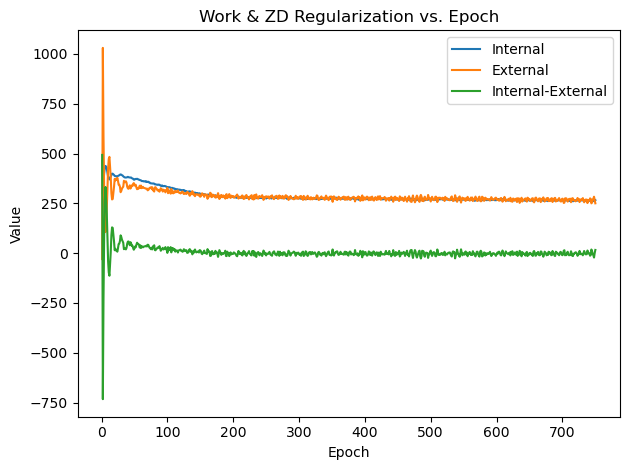

In [79]:
import matplotlib.pyplot as plt

# assume work_dict already exists, with lists of length N for each key
epochs = list(range(1, len(work_dict['Internal']) + 1))
# turn your lists into arrays
internal = np.array(work_dict['Internal'])
external = np.array(work_dict['External'])

# now subtraction works element‐wise
diff = internal - external
plt.figure()
plt.plot(epochs, work_dict['Internal'], label='Internal')
plt.plot(epochs, work_dict['External'], label='External')
plt.plot(epochs,diff, label='Internal-External')
#plt.plot(epochs, work_dict['ZD'], label='ZD')
#plt.plot(epochs, work_dict['Special'], label='Special')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Work & ZD Regularization vs. Epoch')

plt.legend()
plt.tight_layout()
plt.show()


## Export

In [142]:
model.eval()
time_idx=10

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)

In [143]:
for i in range(vf_number):
    tensor1 = VF_values[i,:,:].cpu()        # shape [1000,3]

    name='multi_VF_'+str(i)+'.txt'
    with open(name,'w') as f:
        for i, (x, y, z) in enumerate(tensor1.tolist(), start=1):
            f.write(f"{i},{x},{y},{z}\n")


# Parameter Recovery

In [149]:
model.eval()
time_idx=10

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)
#Vz=construct_VF(V_NN[20:30],delta_xyz)

#VF=torch.cat((Vx.unsqueeze(1),Vy.unsqueeze(1),Vz.unsqueeze(1)), dim=1)
grad_VF= construct_VF_gradients_batch(V_NN, delta_xyz)

#Strain
virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3)) #.detach().cpu().numpy()

In [150]:
# volumetric term:  ∑e  tr(Ereal)[e] * tr(Vvirt)[k,e] * vol_s[e]
A1 = torch.einsum('eii,kejj,e->ke',
                strain_tensor_3d[:,:,:,time_idx],    # <-- must be first, shape [125,3,3]
                virtual_strain,      # <-- second, shape [2,125,3,3]
                volume_tensor[:,0,time_idx])# <-- third, shape [125]
# A1.shape == [vf_number, Nelements] == [2,125]

# deviatoric (full inner‐product) term:
A2 = torch.einsum('eij,keij,e->ke',
                strain_tensor_3d[:,:,:,time_idx],    # [125,3,3]
                virtual_strain,      # [2,125,3,3]|
                volume_tensor[:,0,time_idx])# [125]


A = torch.stack([A1, A2], dim=1)       # → [2, n_vf, Ne]
M = A.mean(dim=2)                      # → [2, n_vf]

In [152]:
M /M.sum(dim=0, keepdim=True) 

tensor([[ 1.1005,  0.2404],
        [-0.1005,  0.7596]], dtype=torch.float32, grad_fn=<DivBackward0>)

In [ ]:
#Sanity check for trace components
#torch.trace(strain_tensor_3d[0,:,:,time_idx])*torch.trace(virtual_strain[0,0])*volume_tensor[0,0,time_idx],torch.trace(strain_tensor_3d[0,:,:,time_idx])*torch.trace(virtual_strain[1,0])*volume_tensor[0,0,time_idx]

(tensor(0.0001, dtype=torch.float32, grad_fn=<MulBackward0>),
 tensor(9.6422e-06, dtype=torch.float32, grad_fn=<MulBackward0>))

In [ ]:
#A[0,:,0],A[:,0,0]

(tensor([-7.0113e-05,  1.1994e-04], dtype=torch.float32,
        grad_fn=<SelectBackward0>),
 tensor([-7.0113e-05, -1.3731e-06], dtype=torch.float32,
        grad_fn=<SelectBackward0>))

In [ ]:
#torch.sum(strain_tensor_3d[30,:,:,time_idx]*virtual_strain[0,30]*volume_tensor[30,0,time_idx]), torch.sum(strain_tensor_3d[30,:,:,time_idx]*virtual_strain[1,30]*volume_tensor[30,0,time_idx])

(tensor(-0.0002, dtype=torch.float32, grad_fn=<SumBackward0>),
 tensor(-5.2361e-05, dtype=torch.float32, grad_fn=<SumBackward0>))

In [ ]:
#A[:,1,30]

tensor([-2.2968e-04, -5.2361e-05], dtype=torch.float32,
       grad_fn=<SelectBackward0>)

In [ ]:
##A[:,0,0]

tensor([-7.0113e-05, -1.3731e-06], dtype=torch.float32,
       grad_fn=<SelectBackward0>)

In [ ]:
#A.shape, strain_tensor_3d.shape, virtual_strain.shape

(torch.Size([2, 2, 125]),
 torch.Size([125, 3, 3, 11]),
 torch.Size([2, 125, 3, 3]))

In [153]:
#Adding negative to the pressure becuase it is applied downwards...
t_surface=surface_normal_tensor[facet_idxs,:,s]*(-100000)*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
#   print(f'W_int shape: {W_int.shape}')
dot = (VF_values[:,elem_idxs,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

W_ext=torch.sum(dot*area_tensor[facet_idxs,:,s].T,dim=(1))/(N_pressure_dofs*vf_number)

In [154]:
#Parameters
torch.matmul(W_ext,torch.inverse(M)).detach().cpu().numpy()

array([1283439.5, -310967.1], dtype=float32)

In [105]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

Vx(x,y,z) = -0.045*1 + +0.226*x + +0.120*y + -0.065*z + -0.008*x**2 + +0.312*x*y + -0.007*x*z + +0.391*y**2 + +0.286*y*z + -0.241*z**2
Vy(x,y,z) = +0.019*1 + +0.031*x + -0.066*y + +0.237*z + -0.144*x**2 + -0.067*x*y + -0.168*x*z + +0.000*y**2 + -0.067*y*z + +0.263*z**2
Vz(x,y,z) = +0.043*1 + -0.044*x + +0.079*y + -0.212*z + +0.117*x**2 + +0.065*x*y + +0.487*x*z + -0.109*y**2 + +0.018*y*z + +0.263*z**2


In [106]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = -0.020*1 + +0.146*x + +0.189*y + -0.163*z + +0.038*x**2 + +0.278*x*y + +0.047*x*z + +0.293*y**2 + +0.259*y*z + -0.404*z**2
Vy(x,y,z) = -0.247*1 + -0.078*x + -0.408*y + -0.746*z + +0.724*x**2 + +0.086*x*y + +0.802*x*z + +0.002*y**2 + +0.156*y*z + +0.080*z**2
Vz(x,y,z) = -0.000*1 + +0.047*x + -0.133*y + -0.072*z + +0.132*x**2 + -0.463*x*y + -0.206*x*z + +0.192*y**2 + +0.008*y*z + -0.289*z**2
